In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

from typing import TypedDict

from utils.plots import setup_datetime_axis
from utils import read_metrics_file, z_score
from utils.constants import WINDOW_SIZE, Events, EWM_ALPHA, METRICS, datetimes, OFFSET

import multiprocessing as mp

import warnings


warnings.filterwarnings("ignore")

In [3]:
class MetricsSummary(TypedDict):
    """
    Structure for metrics summary data.

    Attributes:
        date (str): The date of the event.
        station (str): The station name.
        metric (str): The name of the calculated metric.
        index (str): The calculated metrics for the station.
    """

    date: str
    station: str
    metric: str
    index: str


EVENT: Events = "Forbush Decrease"
MAX_SAMPLES: int = 10  # Samples per date
REPETITION: bool = True  # If True, it will repeat stations already calculated
EWM: bool = True  # If True, it will calculate EWM metrics

event_replace: str = EVENT.replace(" ", "")

In [4]:
plot_stations: dict[str, list[str]] = {
    date: list(
        set(
            map(
                # Get Station name from filename
                lambda filename: filename.name.strip().split("_", 1)[0].upper(),
                Path(f"./data/{event_replace}/{date}").glob("*.csv"),
            )
        )
    )
    for date in datetimes
}

## Summary

In [44]:
def valid_interval(
    event: Events,
    date: str,
    station: str,
    data: pd.DataFrame = None,
) -> pd.DataFrame:
    if data is None:
        suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
        data = read_metrics_file(
            event,
            date,
            station,
            WINDOW_SIZE,
            datetime_cols={"datetime": None},
            suffix=suffix,
        ).set_index("datetime")

    if station in datetimes[date]["stations"] and datetimes[date]["stations"][station]:
        min_datetime = datetimes[date]["stations"][station][0]
    else:
        min_datetime = datetimes[date]["bounds"][0]

    data = data[(data["window_shape"] == WINDOW_SIZE) & (data.index <= min_datetime)]
    return data


def process_derivatives(
    event: Events, date: str, station: str, percentil: int = 0.95
) -> list[MetricsSummary]:
    assert 0 < percentil < 1.0, "Percentil must be between 0.0 and 1.0"

    suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
    data = read_metrics_file(
        event,
        date,
        station,
        WINDOW_SIZE,
        datetime_cols={"datetime": None},
        suffix=suffix,
    ).set_index("datetime")

    metrics_columns = list(filter(lambda col: col in METRICS, data.columns))
    metrics_columns += ["value"]

    # First derivate and filter by valid interval
    # valid_indexes = valid_interval(event, date, station, data).index
    # diff = data[metrics_columns].diff()
    # interest_df = diff[diff.index.isin(valid_indexes)]

    # First filter by valid interval and then derivate
    valid_df = valid_interval(event, date, station, data)
    interest_df = valid_df[metrics_columns].diff()

    quantiles = interest_df.quantile(percentil)

    results: list[MetricsSummary] = []
    for col in metrics_columns:
        quantil = quantiles[col]
        points = interest_df[interest_df[col] >= quantil][col]
        if len(points) < 0:
            continue

        interest_index = points.idxmax()  # Maybe this operation can be changed
        results.append(
            {
                "date": date,
                "station": station,
                "metric": col,
                "index": str(interest_index),
            }
        )

    return results

In [45]:
percentil: float = 0.9

arguments: list[tuple[Events, str, str, int]] = list(
    map(
        lambda date, station: ("Forbush Decrease", date, station, percentil),
        *zip(
            *[
                (date, station)
                for date, stations in plot_stations.items()
                for station in stations
            ]
        ),
    )
)

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = pool.starmap(
        process_derivatives,
        arguments,
    )

In [46]:
df = pd.DataFrame(columns=["date", "station", "metric", "index"])
for res in results:
    df = pd.concat([df, pd.DataFrame(res)], ignore_index=True)

df["index"] = pd.to_datetime(df["index"])
df

,date,station,metric,index
0,2023-04-23,APTY,entropy,2023-04-23 01:06:00
1,2023-04-23,APTY,sampen,2023-04-23 01:06:00
2,2023-04-23,APTY,permutation_entropy,2023-04-23 04:48:00
3,2023-04-23,APTY,shannon_entropy,2023-04-23 06:11:00
4,2023-04-23,APTY,spectral_entropy,2023-04-23 02:16:00
...,...,...,...,...
475,2024-05-10,JBGO,katz_fd,2024-05-10 10:51:00
476,2024-05-10,JBGO,petrosian_fd,2024-05-10 05:08:00
477,2024-05-10,JBGO,lepel_ziv,2024-05-10 03:54:00
478,2024-05-10,JBGO,corr_dim,2024-05-10 08:15:00


In [23]:
suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
df.to_csv(
    f"./data/{event_replace}/summary_derivatives{suffix}.csv",
    index=False,
)

## Results

In [39]:
suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
df = pd.read_csv(f"./data/{event_replace}/summary_derivatives{suffix}.csv")
df["index"] = pd.to_datetime(df["index"])
df

,date,station,metric,index
0,2023-04-23,APTY,entropy,2023-04-23 01:06:00
1,2023-04-23,APTY,sampen,2023-04-23 01:06:00
2,2023-04-23,APTY,permutation_entropy,2023-04-23 04:48:00
3,2023-04-23,APTY,shannon_entropy,2023-04-23 06:11:00
4,2023-04-23,APTY,spectral_entropy,2023-04-23 02:16:00
...,...,...,...,...
475,2024-05-10,JBGO,katz_fd,2024-05-10 10:51:00
476,2024-05-10,JBGO,petrosian_fd,2024-05-10 05:08:00
477,2024-05-10,JBGO,lepel_ziv,2024-05-10 03:54:00
478,2024-05-10,JBGO,corr_dim,2024-05-10 08:15:00


### Violin Plots

In [40]:
delta_hours: list[float] = []
start_datetimes: list[pd.Timestamp] = []

date_events = df["date"].unique()
for date in date_events:
    stations = df[df["date"] == date]["station"].unique()
    for station in stations:
        metrics = df[(df["date"] == date) & (df["station"] == station)]

        if (
            station in datetimes[date]["stations"]
            and datetimes[date]["stations"][station]
        ):
            start_datetime = datetimes[date]["stations"][station][0]
        else:
            start_datetime = datetimes[date]["bounds"][0]

        start_datetime = pd.to_datetime(start_datetime)

        for _, row in metrics.iterrows():
            delta = (start_datetime - row["index"]).total_seconds() / 3600.0
            start_datetimes.append(start_datetime)
            delta_hours.append(delta)


In [41]:
new_df = df.copy()
new_df["start_datetime"] = start_datetimes
new_df["delta_hours"] = delta_hours
new_df

,date,station,metric,index,start_datetime,delta_hours
0,2023-04-23,APTY,entropy,2023-04-23 01:06:00,2023-04-23 18:55:00,17.816667
1,2023-04-23,APTY,sampen,2023-04-23 01:06:00,2023-04-23 18:55:00,17.816667
2,2023-04-23,APTY,permutation_entropy,2023-04-23 04:48:00,2023-04-23 18:55:00,14.116667
3,2023-04-23,APTY,shannon_entropy,2023-04-23 06:11:00,2023-04-23 18:55:00,12.733333
4,2023-04-23,APTY,spectral_entropy,2023-04-23 02:16:00,2023-04-23 18:55:00,16.650000
...,...,...,...,...,...,...
475,2024-05-10,JBGO,katz_fd,2024-05-10 10:51:00,2024-05-10 17:49:00,6.966667
476,2024-05-10,JBGO,petrosian_fd,2024-05-10 05:08:00,2024-05-10 17:49:00,12.683333
477,2024-05-10,JBGO,lepel_ziv,2024-05-10 03:54:00,2024-05-10 17:49:00,13.916667
478,2024-05-10,JBGO,corr_dim,2024-05-10 08:15:00,2024-05-10 17:49:00,9.566667


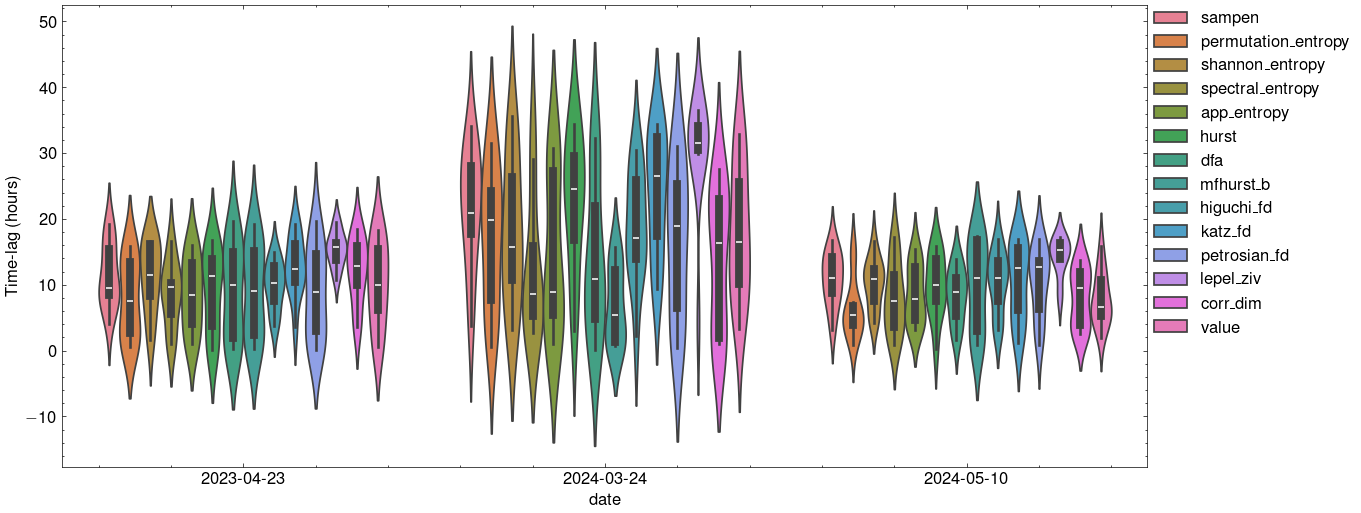

In [42]:
_, ax = plt.subplots(figsize=(14, 6))

sns.violinplot(
    data=new_df[new_df["metric"] != "entropy"],
    x="date",
    y="delta_hours",
    hue="metric",
    inner="box",
    scale="width",
    ax=ax,
)

ax.set_ylabel("Time-lag (hours)")

ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)
plt.savefig(f"./figures/{event_replace}/violin_derivatives{suffix}.pdf", bbox_inches="tight")
plt.show()

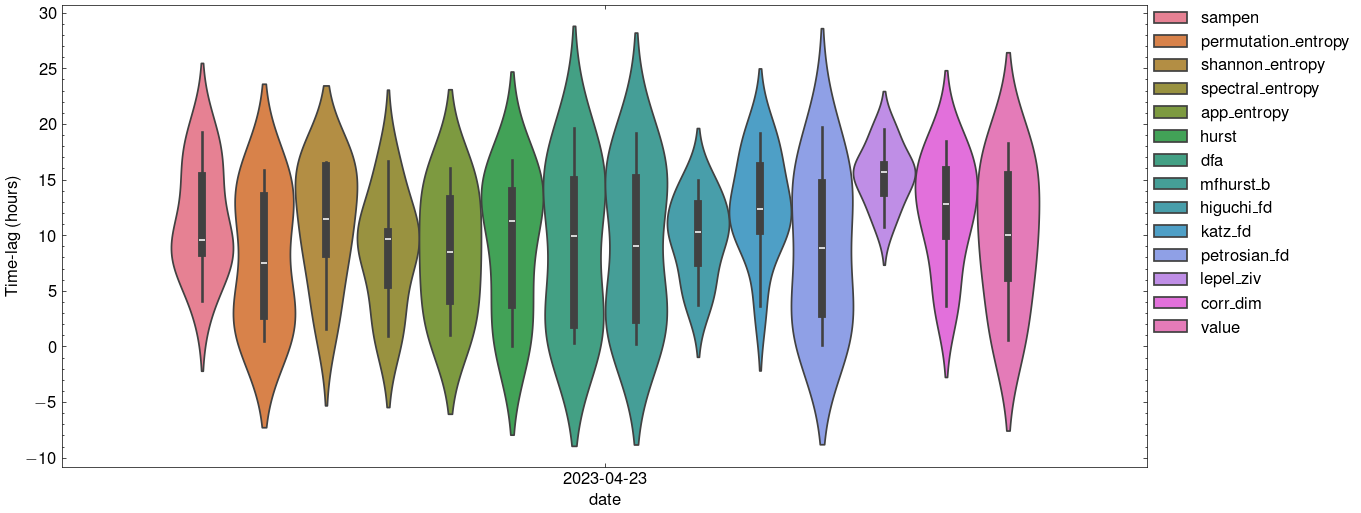

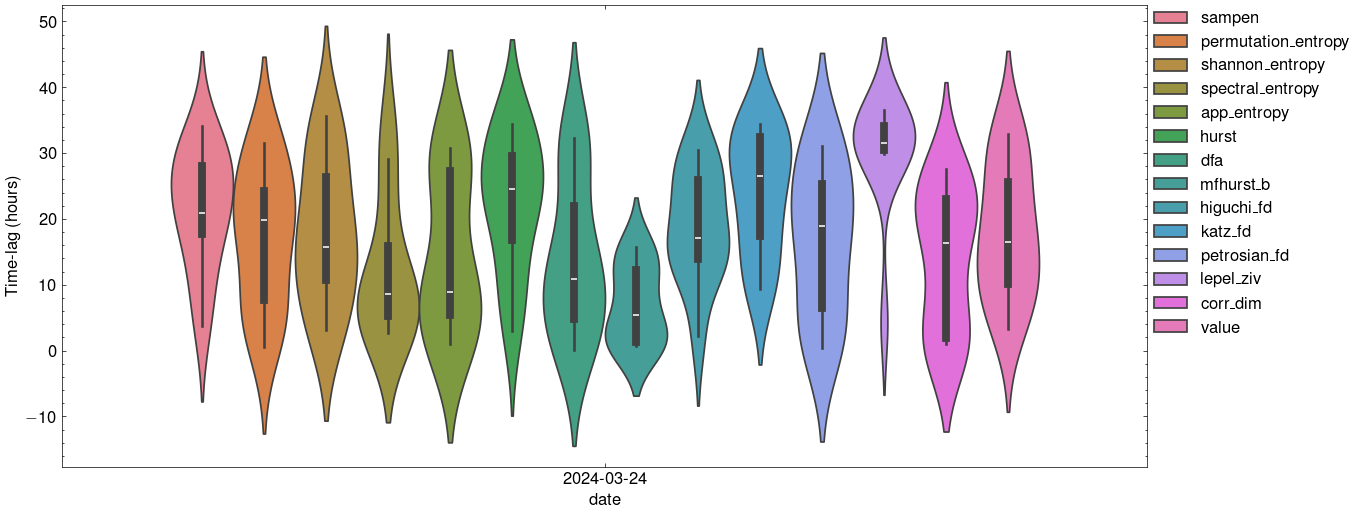

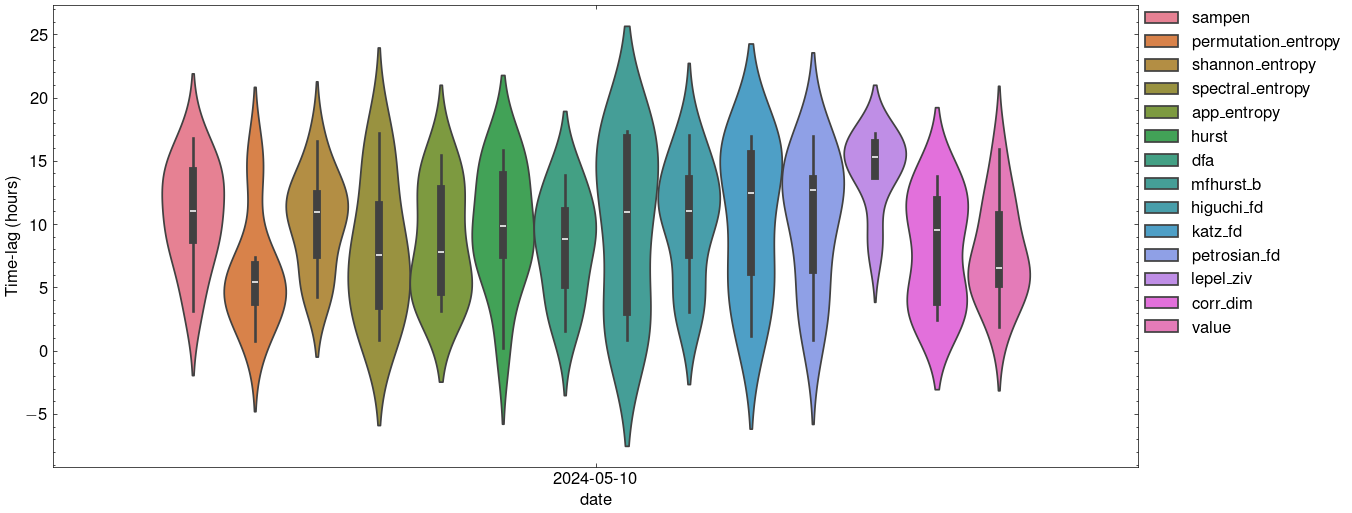

In [43]:
for date in date_events:
    _, ax = plt.subplots(figsize=(14, 6))

    sns.violinplot(
        data=new_df[(new_df["metric"] != "entropy") & (new_df["date"] == date)],
        x="date",
        y="delta_hours",
        hue="metric",
        inner="box",
        scale="width",
        ax=ax,
    )

    ax.set_ylabel("Time-lag (hours)")

    ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)
    plt.savefig(f"./figures/{event_replace}/violin_derivatives-{date}{suffix}.pdf", bbox_inches="tight")
    plt.show()

### Simple plot for testing

In [33]:
# filter by a particular event
date = "2024-03-24"
station = "SOPO"

df_event = df[(df["date"] == date) & (df["station"] == station)].reset_index(drop=True)
df_event = df_event[df_event["metric"] != "entropy"]

df_orig = read_metrics_file(
    EVENT,
    date,
    station,
    WINDOW_SIZE,
    datetime_cols={"datetime": None},
    suffix=suffix,
).set_index("datetime")


display(df_event, df_orig)

,date,station,metric,index
1,2024-03-24,SOPO,sampen,2024-03-23 18:56:00
2,2024-03-24,SOPO,permutation_entropy,2024-03-23 02:58:00
3,2024-03-24,SOPO,shannon_entropy,2024-03-23 20:34:00
4,2024-03-24,SOPO,spectral_entropy,2024-03-23 23:34:00
5,2024-03-24,SOPO,app_entropy,2024-03-23 02:58:00
6,2024-03-24,SOPO,hurst,2024-03-24 00:38:00
7,2024-03-24,SOPO,dfa,2024-03-23 04:24:00
8,2024-03-24,SOPO,mfhurst_b,2024-03-24 08:56:00
9,2024-03-24,SOPO,higuchi_fd,2024-03-23 18:28:00
10,2024-03-24,SOPO,katz_fd,2024-03-24 00:14:00


,value,window_shape,entropy,sampen,permutation_entropy,shannon_entropy,spectral_entropy,app_entropy,hurst,dfa,mfhurst_b,higuchi_fd,katz_fd,petrosian_fd,lepel_ziv,corr_dim
datetime,,,,,,,,,,,,,,,,
2024-03-23 00:00:00,267.760000,65,4.174384,1.925291,2.522552,1.832344,0.626113,0.546042,0.913902,1.184722,0.264600,1.595064,2.139140,1.047682,16,1.175943
2024-03-23 00:02:00,266.895135,66,4.189651,1.812379,2.523714,1.827431,0.625820,0.536785,0.915969,1.179570,0.273979,1.588695,2.135597,1.048126,16,1.168055
2024-03-23 00:04:00,265.274091,67,4.204689,1.714798,2.516538,1.821896,0.629195,0.526649,0.915969,1.193433,0.274775,1.576784,2.139388,1.047263,16,1.185801
2024-03-23 00:06:00,266.697512,68,4.219504,1.773067,2.508548,1.838673,0.626476,0.518829,0.915969,1.192954,0.267078,1.570534,2.179755,1.046428,16,1.181896
2024-03-23 00:08:00,266.928726,69,4.234103,1.773067,2.518114,1.851516,0.628550,0.517801,0.915969,1.202731,0.268361,1.576571,2.178336,1.046863,17,1.183704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 11:50:00,260.426430,70,4.248489,1.043350,2.446415,1.983189,0.474150,0.563835,0.821154,1.629194,0.453747,1.575244,1.552000,1.041154,13,1.280417
2024-03-26 11:52:00,260.531215,69,4.234101,1.029619,2.458292,2.030633,0.476276,0.542966,0.897640,1.942494,0.457578,1.568636,1.609670,1.041873,12,1.261648
2024-03-26 11:54:00,260.677283,68,4.219502,1.111858,2.450559,2.023752,0.475376,0.541878,0.846601,1.818832,0.455276,1.561218,1.660464,1.041339,12,1.229247


In [36]:
def tmp_plots(
    df_orig: pd.DataFrame,
    df_event: pd.DataFrame,
    date: str,
    station: str,
    freq_hours: int = 2,
) -> None:
    metrics_columns = list(
        filter(lambda col: col in df_orig.columns, df_event["metric"].unique())
    )

    if station in datetimes[date]["stations"] and datetimes[date]["stations"][station]:
        start_datetime = datetimes[date]["stations"][station][0]
    else:
        start_datetime = datetimes[date]["bounds"][0]

    start_datetime = pd.to_datetime(start_datetime)

    fig, axes = plt.subplots(7, 2, figsize=(15, 21))

    for metric, ax in zip(metrics_columns, axes.flatten()):
        setup_datetime_axis(ax, freq_hours)
        ax.grid(True, which="major", alpha=0.8, linestyle="--")

        if metric == "value":
            plot_df = df_orig[[metric]].copy()
            derivate_point = df_event[df_event["metric"] == metric]["index"].values[0]

            ax.plot(
                plot_df.index,
                plot_df[metric],
                label="Original Data",
                color="tab:blue",
                linewidth=1.5,
            )
            ax.axvline(
                x=derivate_point,
                color="red",
                linestyle="--",
                label="Detected Point",
                linewidth=1.5,
            )
            ax.axvline(
                x=start_datetime,
                color="black",
                linestyle="--",
                label="Event Start",
                linewidth=1.5,
            )

            ax.set_title(
                f"Original Data - {station.upper()}", fontsize=14, fontweight="bold"
            )
            ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)
            continue

        plot_df = df_orig[[metric, "value"]].copy()
        derivate_point = df_event[df_event["metric"] == metric]["index"].values[0]
        derivate_orig_point = df_event[df_event["metric"] == "value"]["index"].values[0]

        plot_df[[metric, "value"]] = z_score(plot_df, [metric, "value"])
        for i, col in enumerate([metric, "value"]):
            plot_df[col] = plot_df[col] + OFFSET * i

        ax.plot(
            plot_df.index,
            plot_df[metric],
            label=metric,
            color="tab:orange",
            linewidth=1.5,
        )
        ax.plot(
            plot_df.index,
            plot_df["value"],
            label="Original Data",
            color="tab:blue",
            linewidth=1.5,
        )
        ax.axvline(
            x=derivate_orig_point,
            color="red",
            linestyle="--",
            label="Original Data Point",
            linewidth=1.5,
        )
        ax.axvline(
            x=derivate_point,
            color="green",
            linestyle="--",
            label=f"Detected Point: {
                derivate_point.astype('datetime64[us]').item().strftime('%m-%d %H:%M')
            }",
            linewidth=1.5,
        )
        ax.axvline(
            x=start_datetime,
            color="black",
            linestyle="--",
            label="Event Start",
            linewidth=1.5,
        )
        ax.set_title(
            f"Original {metric} - {station.upper()}", fontsize=14, fontweight="bold"
        )
        ax.set_yticklabels([])

        ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)

    event_start_str = start_datetime.strftime("%Y-%m-%d %H:%M")
    orig_data_point_str = (
        derivate_orig_point.astype("datetime64[us]").item().strftime("%Y-%m-%d %H:%M")
    )

    fig.suptitle(
        f"Event: {EVENT} | Date: {date} | Station: {station.upper()}\nEvent Start: {event_start_str} | Original Data Point: {orig_data_point_str}",
        fontsize=16,
        fontweight="bold",
    )

    fig.tight_layout()
    plt.show()

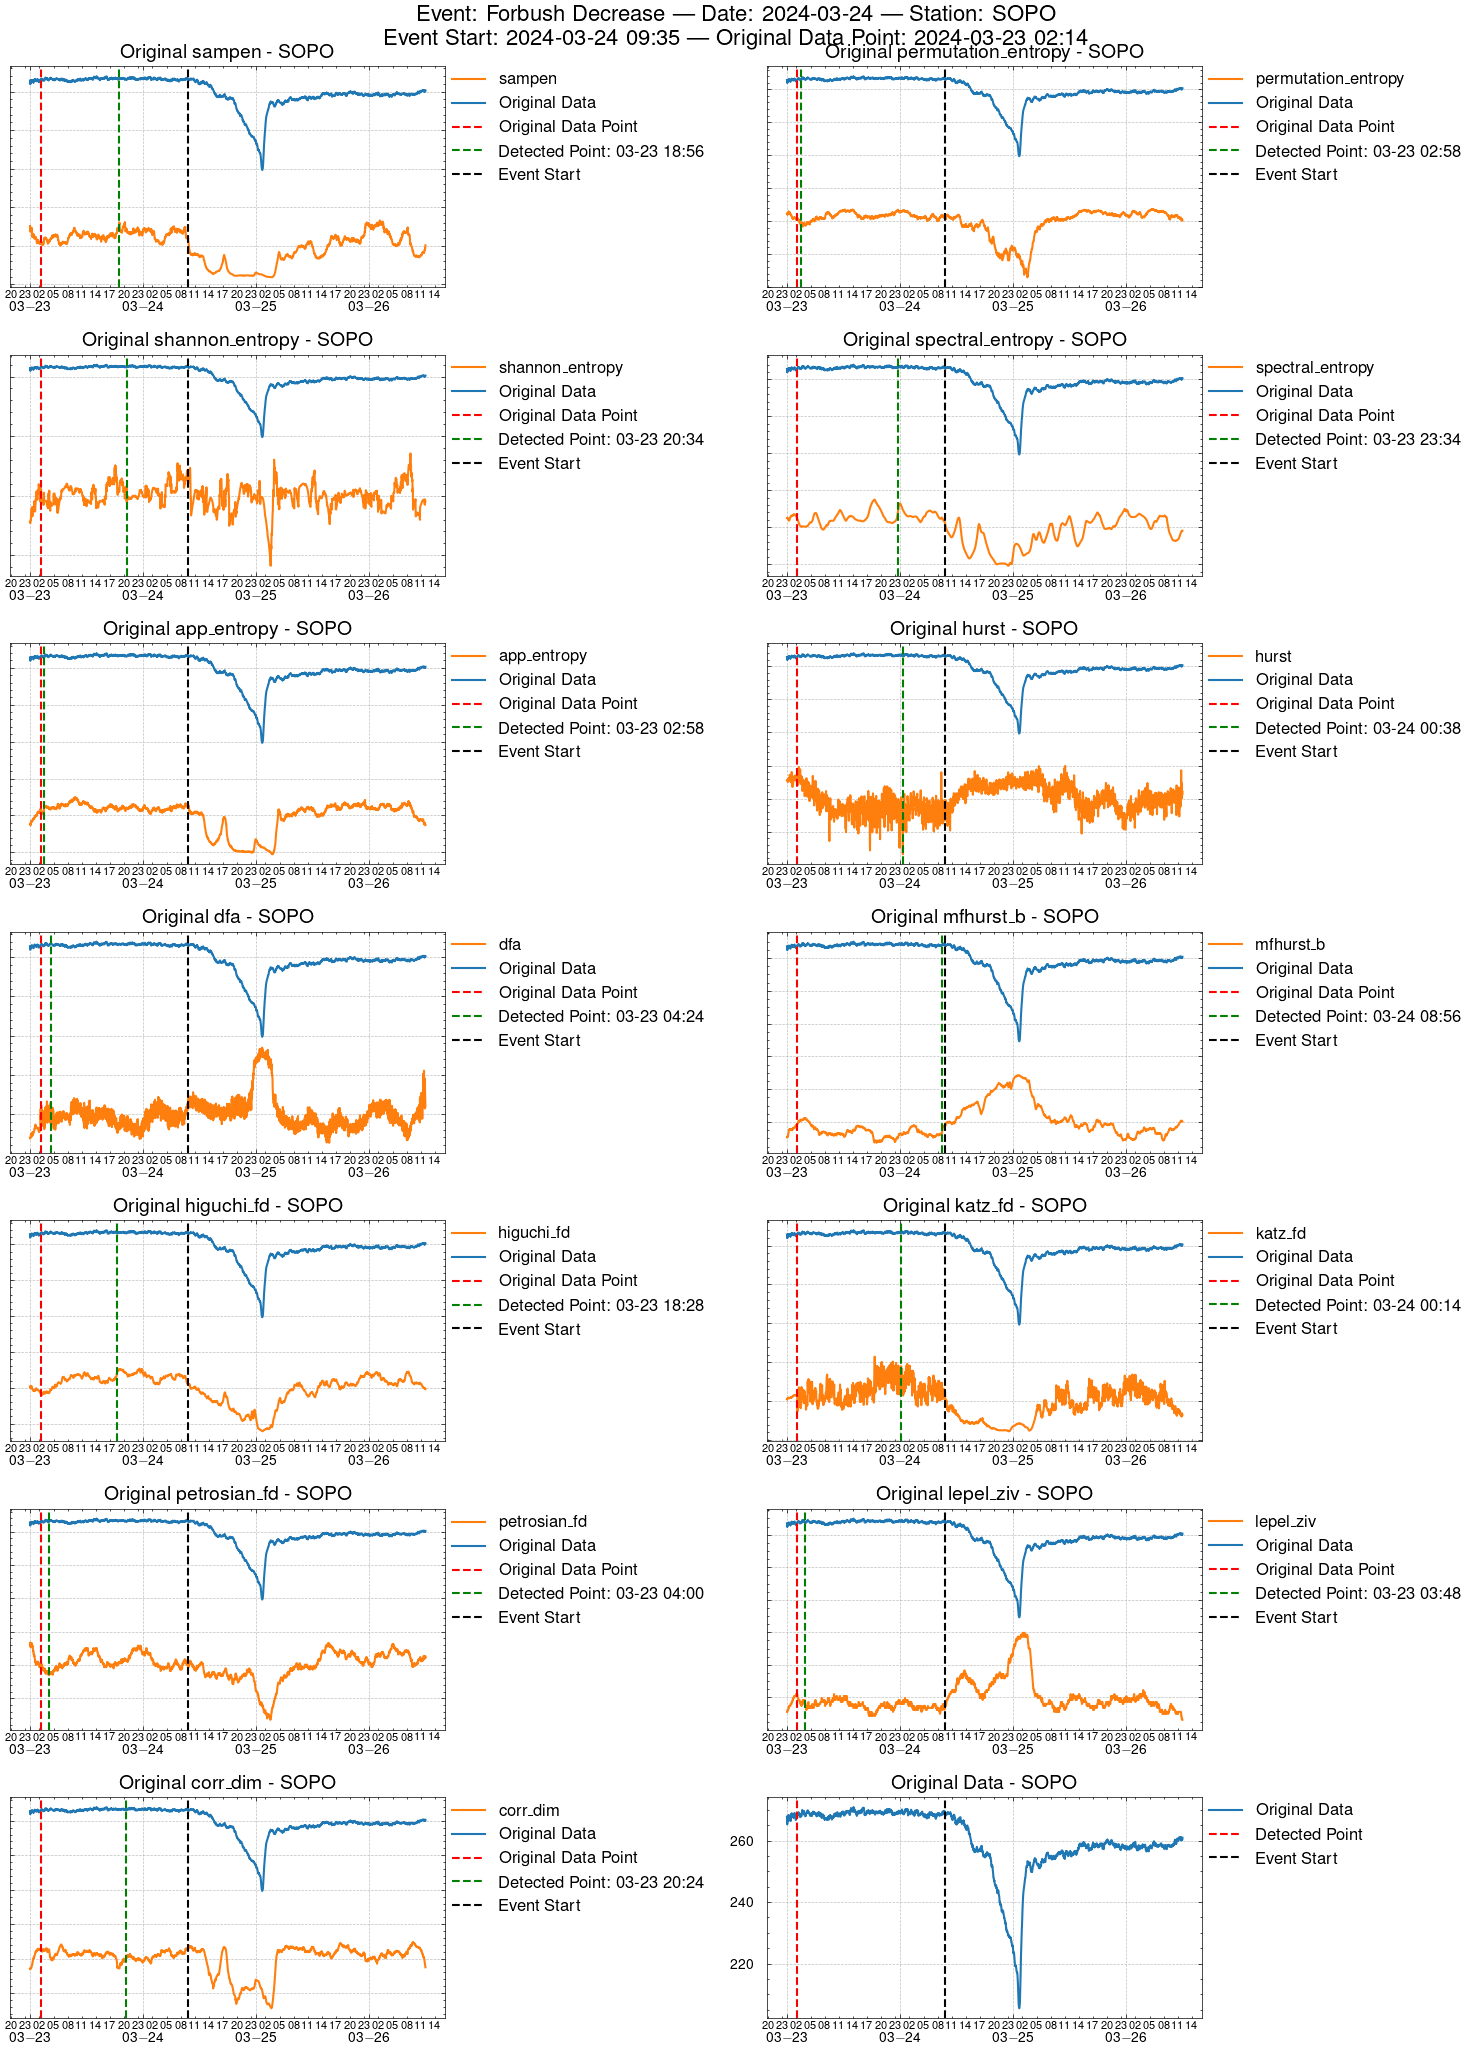

In [38]:
tmp_plots(df_orig, df_event, date, station, freq_hours=3)